<a href="https://colab.research.google.com/github/LiamSwick/Credit-Score-Project/blob/main/Credit_Score_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score

In [2]:
path = kagglehub.dataset_download("parisrohan/credit-score-classification")

print("Path to dataset files:", path)

df = pd.read_csv(path + "/train.csv")

Path to dataset files: /kaggle/input/credit-score-classification


<ipython-input-2-c8cad3162309>:5: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "/train.csv")


In [3]:
pd.set_option('display.max_columns', None)
df.tail()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,6,7,2,"Auto Loan, and Student Loan",23,7,11.5,3.0,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.866228,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,6,7,2,"Auto Loan, and Student Loan",18,7,11.5,3.0,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.65161,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,6,5729,2,"Auto Loan, and Student Loan",27,6,11.5,3.0,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.809083,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,6,7,2,"Auto Loan, and Student Loan",20,NaN,11.5,3.0,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.164979,Standard
99999,0x25fed,CUS_0x942c,August,Nicks,25,078-73-5990,Mechanic,39628.99_,3359.415833,4,6,7,2,"Auto Loan, and Student Loan",18,6,11.5,3.0,Good,502.38,34.192463,31 Years and 10 Months,No,35.104023,167.1638651610451,!@9#%8,393.673696,Poor


In [4]:
print(df.isna().sum())

ID                              0
Customer_ID                     0
Month                           0
Name                         9985
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       15002
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                11408
Delay_from_due_date             0
Num_of_Delayed_Payment       7002
Changed_Credit_Limit            0
Num_Credit_Inquiries         1965
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age           9030
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      4479
Payment_Behaviour               0
Monthly_Balance              1200
Credit_Score                    0
dtype: int64


In [66]:
#df.info()
df_copy = df.copy()

In [67]:
num_cols = ['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance']
for col in num_cols:
  df_copy[col] = pd.to_numeric(df_copy[col], errors = 'coerce')
df_copy.isna().sum()

,0
ID,0
Customer_ID,0
Month,0
Name,9985
Age,4939
SSN,0
Occupation,0
Annual_Income,6980
Monthly_Inhand_Salary,15002
Num_Bank_Accounts,0


In [68]:
df_copy = df_copy.fillna(method='ffill')
df_copy.isna().sum()

<ipython-input-68-1ad55ff6359d>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy = df_copy.fillna(method='ffill')


,0
ID,0
Customer_ID,0
Month,0
Name,0
Age,0
SSN,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,0
Num_Bank_Accounts,0


In [69]:
for col in num_cols:
  print(df_copy[col].agg(['min','median', 'max']))

min       -500.0
median      33.0
max       8698.0
Name: Age, dtype: float64
min           7005.93
median       37654.18
max       24198062.00
Name: Annual_Income, dtype: float64
min         303.645417
median     3089.544583
max       15204.633333
Name: Monthly_Inhand_Salary, dtype: float64
min         -1.0
median       6.0
max       1798.0
Name: Num_Bank_Accounts, dtype: float64
min          0.0
median       5.0
max       1499.0
Name: Num_Credit_Card, dtype: float64
min          1.0
median      13.0
max       5797.0
Name: Interest_Rate, dtype: float64
min       -100.0
median       3.0
max       1496.0
Name: Num_of_Loan, dtype: float64
min       -5.0
median    18.0
max       67.0
Name: Delay_from_due_date, dtype: float64
min         -3.0
median      14.0
max       4397.0
Name: Num_of_Delayed_Payment, dtype: float64
min       -6.49
median     9.40
max       36.97
Name: Changed_Credit_Limit, dtype: float64
min          0.0
median       6.0
max       2597.0
Name: Num_Credit_Inquiries, dty

In [100]:
# Replace outlier values in each column with the appropriate metric
df_copy['Age'] = df_copy['Age'].apply(lambda x: df_copy['Age'].median() if x > 60 or x < 0 else x)
df_copy['Annual_Income'] = df_copy['Annual_Income'].apply(lambda x: df_copy['Annual_Income'].median() if x > 200000 or x < 0 else x)
df_copy['Num_Bank_Accounts'] = df_copy['Num_Bank_Accounts'].apply(lambda x: df_copy['Num_Bank_Accounts'].median() if x > 12 or x < 0 else x)
df_copy['Num_Credit_Card'] = df_copy['Num_Credit_Card'].apply(lambda x: df_copy['Num_Credit_Card'].median() if x > 10 or x < 0 else x)
df_copy['Interest_Rate'] = df_copy['Interest_Rate'].apply(lambda x: df_copy['Interest_Rate'].median() if x > 50 or x < 0 else x)
df_copy['Num_of_Loan'] = df_copy['Num_of_Loan'].apply(lambda x: df_copy['Num_of_Loan'].median() if x > 10 or x < 0 else x)
df_copy['Delay_from_due_date'] = df_copy['Delay_from_due_date'].apply(lambda x: df_copy['Delay_from_due_date'].mean() if x > 31 or x < 0 else x)
df_copy['Num_of_Delayed_Payment'] = df_copy['Num_of_Delayed_Payment'].apply(lambda x: df_copy['Num_of_Delayed_Payment'].median() if x > 30 or x < 0 else x)
df_copy['Num_Credit_Inquiries'] = df_copy['Num_Credit_Inquiries'].apply(lambda x: df_copy['Num_Credit_Inquiries'].median() if x > 15 or x < 0 else x)
df_copy['Total_EMI_per_month'] = df_copy['Total_EMI_per_month'].apply(lambda x: df_copy['Total_EMI_per_month'].median() if x > 1000 or x < 0 else x)

# Check the min/max of Age again to confirm the change
print(df_copy['Age'].agg(['min','median', 'max']))
print(df_copy['Annual_Income'].agg(['min','median', 'max']))
print(df_copy['Num_Bank_Accounts'].agg(['min','median', 'max']))
print(df_copy['Num_Credit_Card'].agg(['min','median', 'max']))
print(df_copy['Interest_Rate'].agg(['min','median', 'max']))
print(df_copy['Num_of_Loan'].agg(['min','median', 'max']))
print(df_copy['Delay_from_due_date'].agg(['min','median', 'max']))
print(df_copy['Num_of_Delayed_Payment'].agg(['min','median', 'max']))
print(df_copy['Num_Credit_Inquiries'].agg(['min','median', 'max']))
print(df_copy['Total_EMI_per_month'].agg(['min','median', 'max']))


min       14.0
median    33.0
max       56.0
Name: Age, dtype: float64
min         7005.93
median     37654.18
max       179987.28
Name: Annual_Income, dtype: float64
min        0.0
median     6.0
max       11.0
Name: Num_Bank_Accounts, dtype: float64
min        0.0
median     5.0
max       10.0
Name: Num_Credit_Card, dtype: float64
min        1.0
median    13.0
max       34.0
Name: Interest_Rate, dtype: float64
min       0.0
median    3.0
max       9.0
Name: Num_of_Loan, dtype: float64
min        0.0
median    18.0
max       31.0
Name: Delay_from_due_date, dtype: float64
min        0.0
median    14.0
max       28.0
Name: Num_of_Delayed_Payment, dtype: float64
min        0.0
median     6.0
max       15.0
Name: Num_Credit_Inquiries, dtype: float64
min         0.000000
median     69.247381
max       999.719279
Name: Total_EMI_per_month, dtype: float64


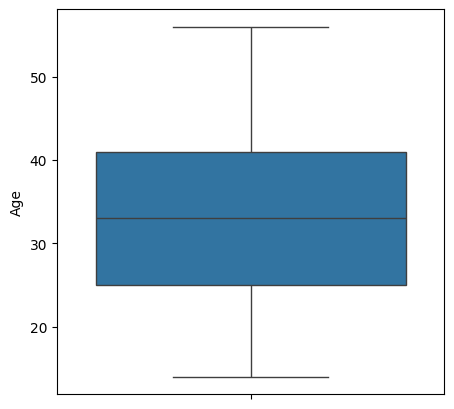

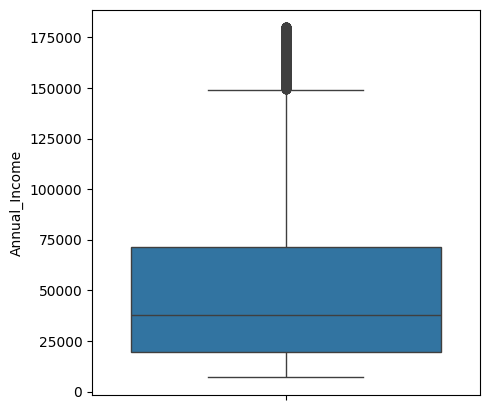

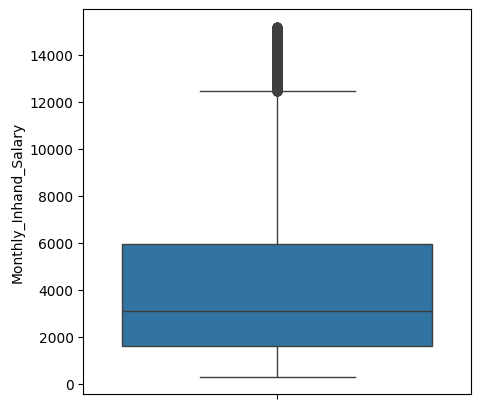

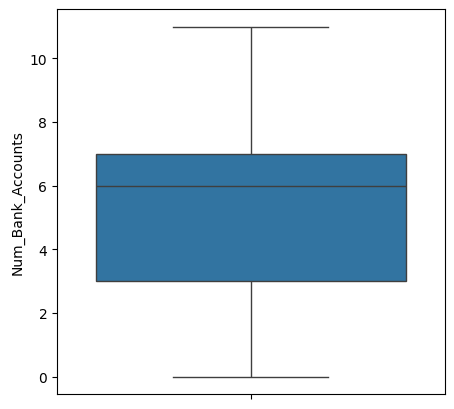

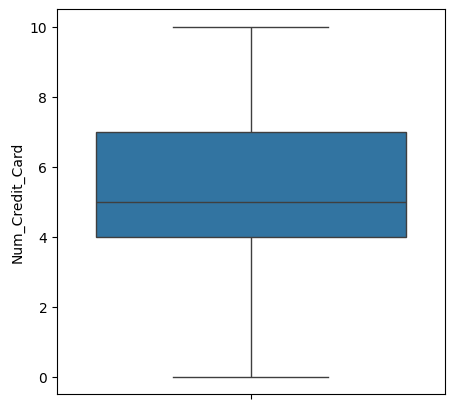

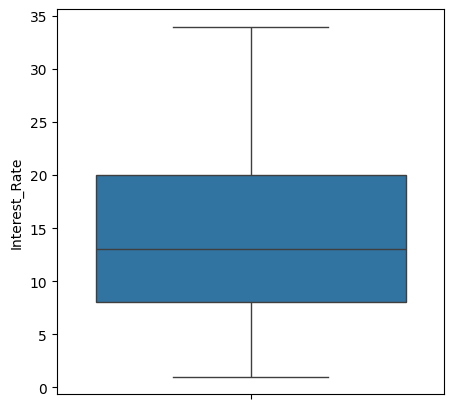

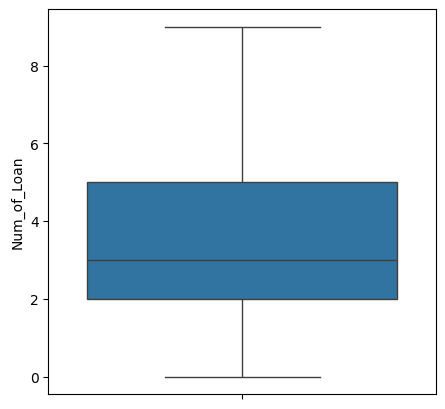

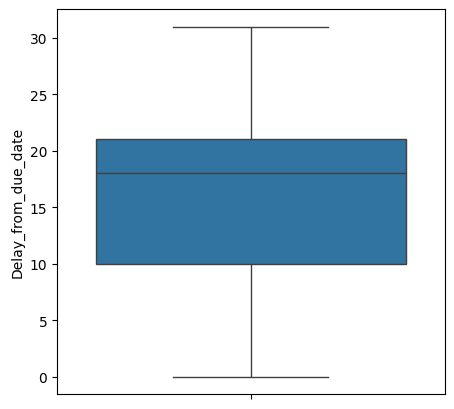

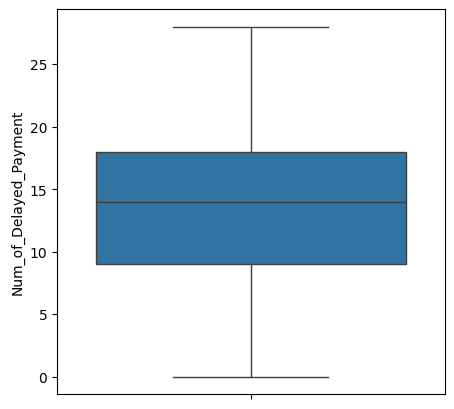

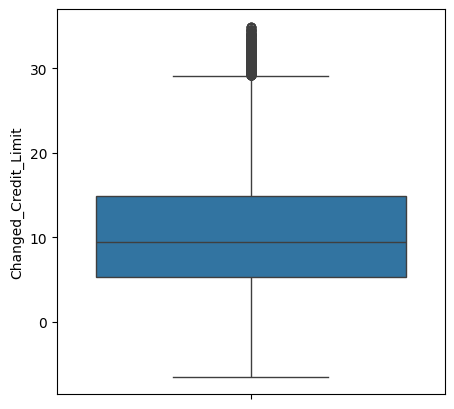

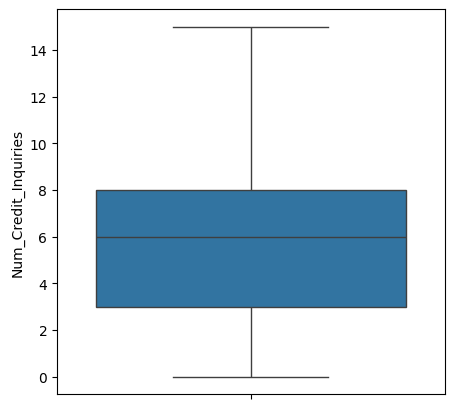

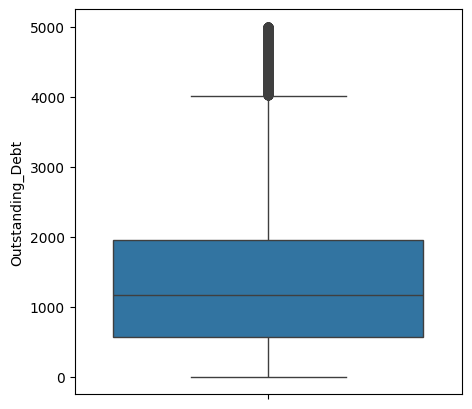

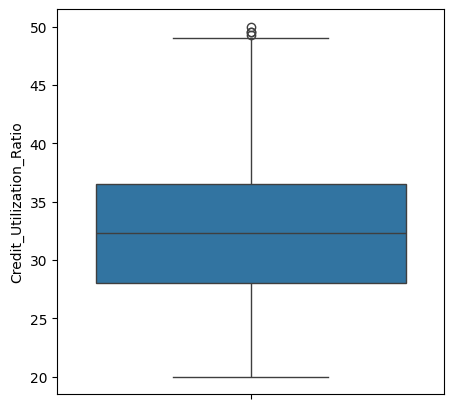

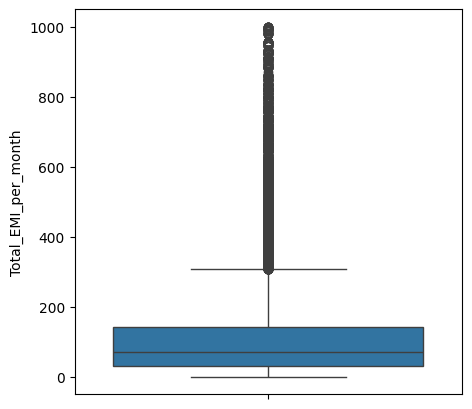

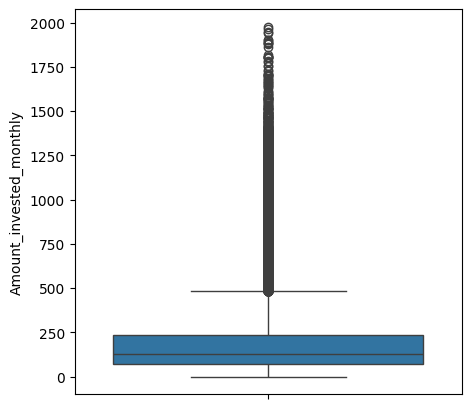

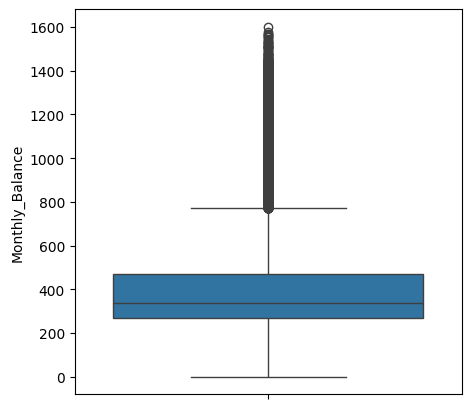

In [101]:
for col in num_cols:
  plt.figure(figsize=(5,5))
  sns.boxplot(df_copy[col])
  plt.show()

In [102]:
# Data integrity step
df_copy = df_copy.drop(['ID', 'Customer_ID','Name','SSN',], axis=1)
df_copy.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,January,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.00000,7.0,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,February,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",21.06878,7.0,11.27,4.0,Good,809.98,31.944960,22 Years and 1 Months,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,March,33.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3.00000,7.0,11.27,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,April,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5.00000,4.0,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,May,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6.00000,4.0,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
